# CSII 2023 Exercise 02: State Feedback for Duckiebot Steering

Reference: 
- [Python Control Systems Library](https://python-control.readthedocs.io/en/0.9.3.post2/steering.html)
- Karl J. Astrom and Richard M. Murray 23 Jul 2019

## State Feedback for Duckiebot Steering
The dynamics of the Duckiebot are given by a simple unicycle model, which is similar to the Duckiebot model presented in the first lecture. We take the state of the system as $(x, y, \theta)$ where $(x, y)$ is the position of the reference point of the Duckiebot in the plane and $\theta$ is the angle of the Duckiebot with respect to the x-axis. The input of the Duckiebot is given by $(v, \omega)$ where $v$ is the forward velocity and $\omega$ is the angular speed. The difference from the lecture formulation is that we use absolute coordinates in global frame $(x, y, \theta)$ for our states and not relative states to our reference line as shown in the figure $(d,\theta)$. 

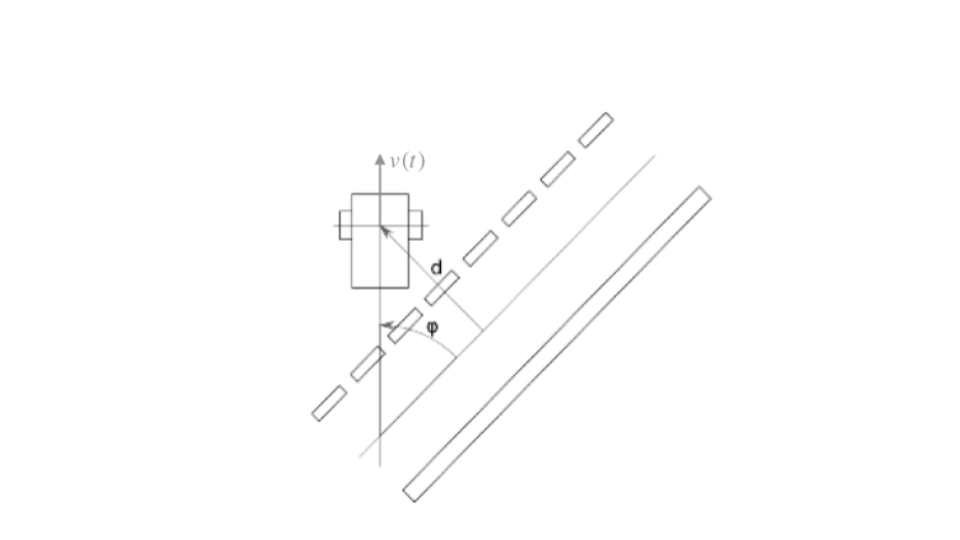

-------
## Requirements
If you have no experience with Python, try to do some tutorials (e.g. check [this](https://docs.python.org/3/tutorial/) one). There are plenty of other Python tutorials for beginners if you do a Google/YouTube search. 

We use the [Python library](https://python-control.readthedocs.io/en/0.9.3.post2/) `control`. Which is already installed in this LX environment.

------
## Python Packages
We use the following Python libraries which need to be imported. If you have no experience with the [NumPy](https://numpy.org/) library, read the documentation and do some tutorials. It is very important for matrix operations in Python.

In [1]:
# Import the required python libraries
from typing import Optional, List
import numpy as np
import matplotlib.pyplot as plt
import control as ct

## Dynamics

The nonlinear dynamics and the output of the Duckiebot are defined in the next cell.

In [2]:
def unicycle_update(t: float, x: np.array, u: np.array, params: dict):
    # Return the derivative of the state
    max_omega = params.get('max_omega', 0.05)
    omega = np.clip(u[1], -max_omega, max_omega)
    return np.array([
        u[0] * np.cos(x[2]),    # xdot = v cos(theta)
        u[0] * np.sin(x[2]),    # ydot = v sin(theta)
        omega     # thdot = w
    ])

def unicycle_output(t: float, x: np.array, u: np.array, params: dict):
    return x[0:2]

## Plotting
We also implemented some plotting functions using the [Matplotlib](https://matplotlib.org/) library as utilities for this notebook that we import below. If you are interested, take a look in the `packages/utils/plotting_utils.py` file.

In [3]:
from utils.plotting_utils import plot_track, plot_step_response, plot_sim_results

## Parameters and Reference Track

We set a default Duckiebot velocity and generate the nonlinear system using the `control` library. 

In [4]:
# Default Duckiebot velocity in m/s
duckie_params={'velocity': 0.1, 'max_omega': 0.05}
# Define the Duckiebot's steering dynamics as an input/output system
duckiebot = ct.NonlinearIOSystem(
    unicycle_update, unicycle_output, states=3, name='duckiebot',
    inputs=('v', 'w'), outputs=('x', 'y'), params=duckie_params)

v0 = duckie_params['velocity']

We define a reference track that we want to follow. If you want to test an easy track, set `curve_difficulty_levels[0]`. For a hard track set `curve_difficulty_levels[1]`. If you want to create your own track, set `curve_difficulty_levels[2]` and change `w_curvy` after the `else` line. The reference line is generated by simulating some given control inputs for a certain time. We keep the velocity input `v_curvy` constant and calculate a forced angluar velocity `w_curvy`.

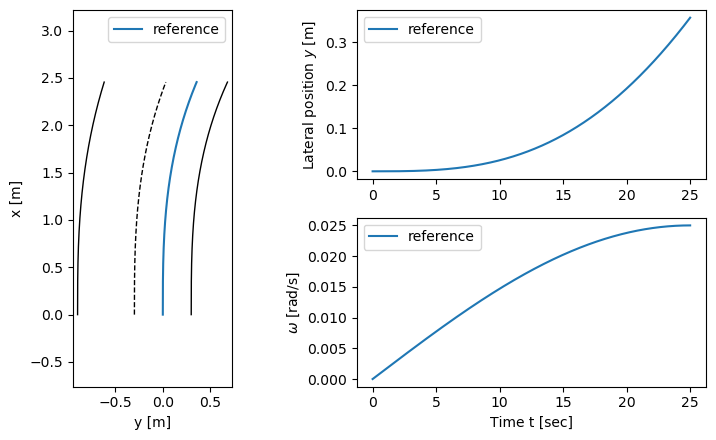

In [5]:
# Control inputs
curve_difficulty_levels = ['easy', 'hard', 'custom']
curve_difficulty = curve_difficulty_levels[0]
T_curvy = np.linspace(0, 25, 500)
v_curvy = v0*np.ones(T_curvy.shape)
if curve_difficulty=='easy':
    w_curvy = 0.025*np.sin(T_curvy*np.pi/50)
elif curve_difficulty=='hard':
    w_curvy = 0.2*np.sin(T_curvy)*np.cos(4*T_curvy) + 0.025*np.sin(T_curvy*np.pi/10)
else:
    w_curvy = 0.2*np.sin(T_curvy)*np.cos(4*T_curvy) + 0.025*np.sin(T_curvy*np.pi/10)
u_curvy = [v_curvy, w_curvy]
X0_curvy = [0, 0, 0]

# Simulate the system + estimator
t_curvy, y_curvy, x_curvy = ct.input_output_response(
    duckiebot, T_curvy, u_curvy, X0_curvy, params=duckie_params, return_x=True)

plot_track(y_curvy[0], y_curvy[1], x_curvy[2], t_curvy, w_curvy)

## Linearization, Normalization and State Space Represenation

In the next cell we show you how you to linearize and normalize the system using the `control` library. As shown in the class, we use $u_1=v_0$ as a constant for simplicity.

In [6]:
# Define the lateral dynamics as a subset of the full Duckiebot steering dynamics
lateral = ct.NonlinearIOSystem(
    lambda t, x, u, params: unicycle_update(
        t, [0., x[0], x[1]], [params.get('velocity', 1), u[0]], params)[1:],
    lambda t, x, u, params: unicycle_output(
        t, [0., x[0], x[1]], [params.get('velocity', 1), u[0]], params)[1:],
    states=2, name='lateral', inputs=('w'), outputs=('y')
)

# Compute the linearization at velocity v0 = 0.1 m/sec
lateral_linearized = ct.linearize(lateral, [0, 0], [0], params=duckie_params)

print("Linearized system dynamics:\n")
print(lateral_linearized)

# Save the system matrices for later use
A = lateral_linearized.A
B = lateral_linearized.B
C = lateral_linearized.C

Linearized system dynamics:

<LinearIOSystem>: sys[2]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (2): ['x[0]', 'x[1]']

A = [[0.  0.1]
     [0.  0. ]]

B = [[0.]
     [1.]]

C = [[1. 0.]]

D = [[0.]]



------
## Exercise 1: Reachability
Write code to check if the linearized and normalized system is reachable. Use only the `numpy` library. 

**NumPy Hints**: 
*   matrix multiplication: `Z = X @ Y`
*   rank of a matrix: `r = np.linalg.matrix_rank(X)`
*   concatination of matrices along column axis: `XY = np.concatenate((X, Y), axis=1)`

If you need further direction, the solutions to this and the following exercises are available in the `02-unicycle-state-feedback-SOLUTION` notebook in this directory.

In [7]:
# Write here the reachability test

--------------

## Exercise 2: Ackermann's formula
Now we want to use the Ackermann'*s* formula to get our closed loop gain. With the `control` library this is very easy. Just use: `K = ct.acker(A,B,poles)`. Try to implement your own version by completing the `acker` function in the `packages/solution/ackerman.py` file using the A and B matrices and a list of poles you want. Try to use only the `numpy` library. We will later test your implementation against the `control` library.

**NumPy Hints**: 
*   matrix inverse: `np.linalg.inv(X)`
*   2x2 identity matrix: `np.identity(2)`

If you need further direction, the solutions to this and the following exercises are available in the `02-unicycle-state-feedback-SOLUTION` notebook in this directory.

--------------

## Exercise 3: Feedforward gain
Try to implement the calculation of the feedforward gain $k_r$ such that the steady state error is $y_{ss}=r$. You should complete your implementation in the `feedforward_kr` function in the `packages/solution/ackerman.py` file.

-----------------

## Pole Placement

We now compute the gains by using either the Ackermann's formula from `control`, the solution of the Exercise 2, or your implementation. 

In [8]:
from solution.ackermann import acker, feedforward_kr
from solution.ackermann_solution import acker_solution, feedforward_kr_solution

def place_poles_Ackermann(A: np.array, B: np.array, C: np.array, 
                          D: float, poles: List, version: str = 'control'):
    if version == 'control':
      K = ct.acker(A,B,poles)
    elif version == 'solution':
      K = acker_solution(A,B,poles)
    elif version == 'exercise':
      K = acker(A,B,poles)
    else:
      raise ValueError("Invalid version")

    # Create a new system representing the closed loop response
    clsys = ct.StateSpace(A - B @ K, B, C, D)
    
    if version == 'exercise':
      kr = feedforward_kr(A, B, C, K)
    else:
      kr = feedforward_kr_solution(A, B, C, K)

    # Scale the input by the feedforward gain
    clsys *= kr

    # Return gains and closed loop system dynamics
    return K, kr, clsys

In the next cell we define our desired poles. Change them if you want. Then in `place_poles_Ackermann(A=A, B=B, C=C, D=0, poles=poles, version='control')` we calculate the gains of the closed loop system. Set `version='control'` if you want to see the gains calculated by `control`, set `version='solution'` to test the solution implementation and `version='exercise'` to test your implementation.

In [9]:
# Place the poles of the system
poles = [-1, -1]

K, kr, clsys = place_poles_Ackermann(A=A, B=B, C=C, D=0, 
                                     poles=poles, version='control')

# Print out the gains
print("K = ", K)
print("kr = ", kr)

K =  [[10.  2.]]
kr =  [[10.]]


## Step Response

First, we test our state feedback controller with a step response.

In [10]:
# Compute the step response
t, y, x = ct.step_response(clsys, np.linspace(0, 20, 100), return_x=True)

In [11]:
# Compute the input used to generate the control response (check lecture slides)
u = -K @ x + kr * 1

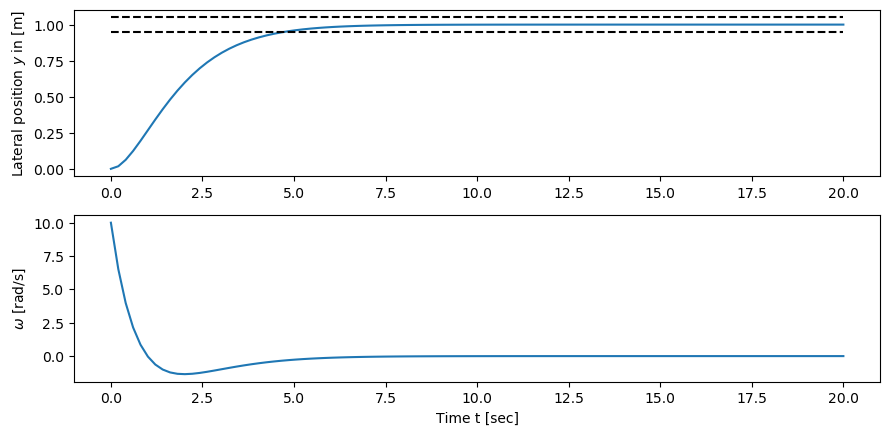

In [12]:
# Configure matplotlib plots to be a bit bigger and optimize layout
plt.figure(figsize=[9, 4.5])
# Plot the results
plot_step_response(t, y, u)
plt.tight_layout()

## Simulation

Finally, we simulate the system to test how the controller performs against our previously defined reference.

In [13]:
x_ref = x_curvy[0]
y_ref = x_curvy[1]
theta_ref = x_curvy[2]
# Simulate the system
t, y, x = ct.forced_response(clsys, T_curvy, y_ref, [0.0, 0.0], return_x=True)

In [14]:
# Calcaluate the input used to generate the control response (check lecture slides)
u_sfb = kr * y_ref - K @ x

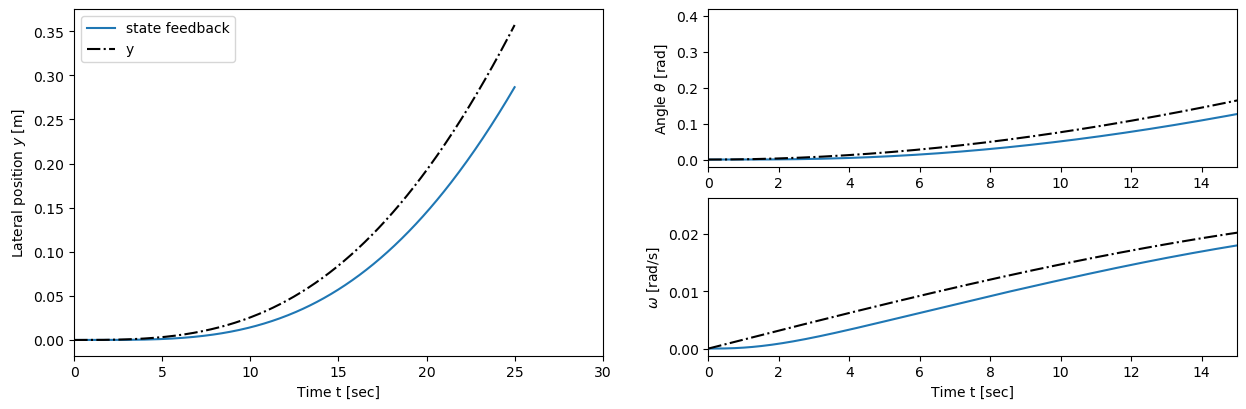

In [15]:
y_ctr = y
plot_sim_results(y_ref=x_curvy[1], y=y_ctr, theta_ref=theta_ref, theta=x[1], t=t, 
                            w_ref=w_curvy, w=u_sfb[0])

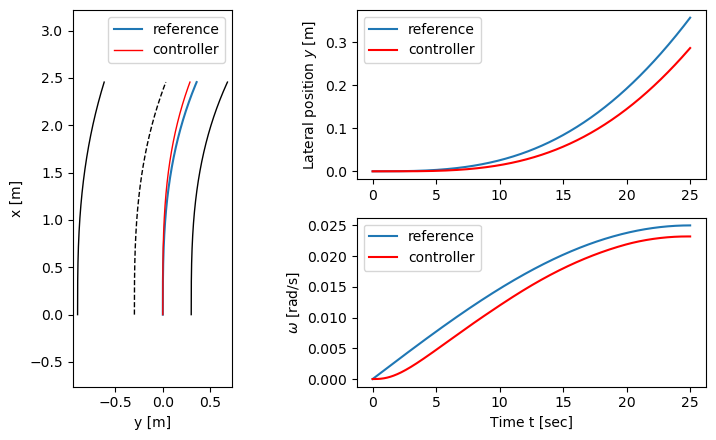

In [16]:
plot_track(y_curvy[0], y_curvy[1], x_curvy[2], t_curvy, w_curvy, 
            y_ctr, u_sfb[0])

## Outlook
- Change the tracks and create your own reference track
- Use different poles and check how the controller performance changes
- Ask ChatGPT for solutions and compare them with your own :) 